# Plotting & Region of Interest 

In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
from herbie import Herbie
import numpy as np

In [20]:
H = Herbie(
    "2021-07-01 12:00",  # model run date
    model="hrrr",  # model name
    product="sfc",  # model produce name (model dependent)
    fxx=0,  # forecast lead time
)

H.download(":VIL:")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-Jul-01 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


PosixPath('/Users/thinhhoang/data/hrrr/20210701/subset_e7ef0967__hrrr.t12z.wrfsfcf00.grib2')

In [21]:
ds = H.xarray(":VIL:")
vil = ds.veril

/Users/thinhhoang/miniforge3/envs/traffic/lib/python3.9/site-packages/herbie/core.py:1052: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


In [22]:
vil['latitude'].values.shape

(1059, 1799)

In [23]:
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Lambert = ccrs.LambertConformal()

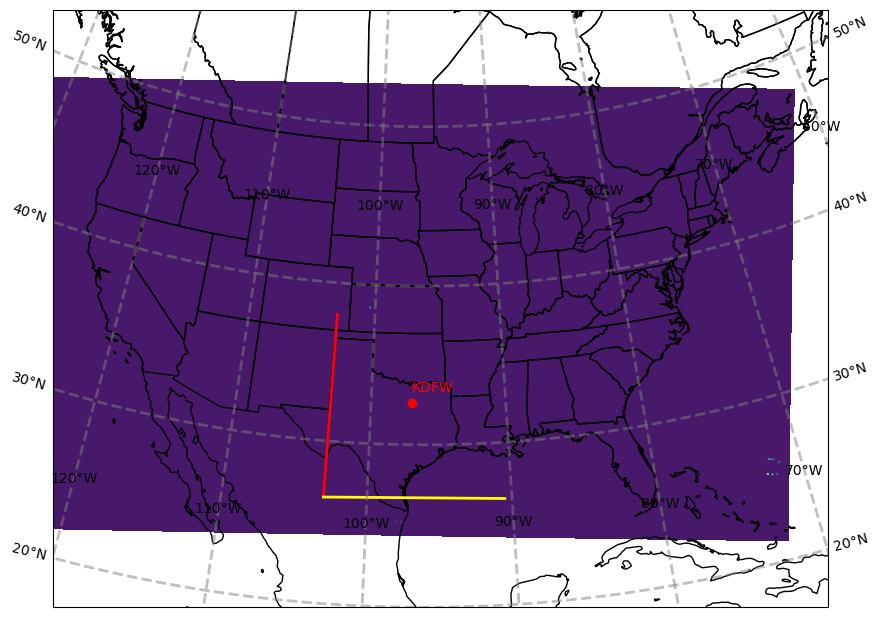

In [35]:
from roi import KDFW, WX_ROI
# Plot the veril using cartopy

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=Lambert)
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.STATES)

# Set the map bounds
ax.set_extent([-120, -70, 20, 55], crs=ccrs.PlateCarree())

# Draw two lines, one for each meridian and parallel that we want to highlight.
ax.plot([WX_ROI[0][0], WX_ROI[0][0]], [WX_ROI[1][0], WX_ROI[1][1]], color='red', transform=ccrs.PlateCarree(), linewidth=2)
ax.plot([WX_ROI[0][0], WX_ROI[0][1]], [WX_ROI[1][0], WX_ROI[1][0]], color='yellow', transform=ccrs.PlateCarree(), linewidth=2)

plt.contourf(vil['longitude'].values, vil['latitude'].values, vil.values, transform=ccrs.PlateCarree())
plt.scatter(KDFW[0], KDFW[1], color='red', transform=ccrs.PlateCarree())
plt.text(KDFW[0], KDFW[1]+0.75, 'KDFW', color='red', transform=ccrs.PlateCarree())

# Show the longitude and latitude grid lines
ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

